### Basic idea

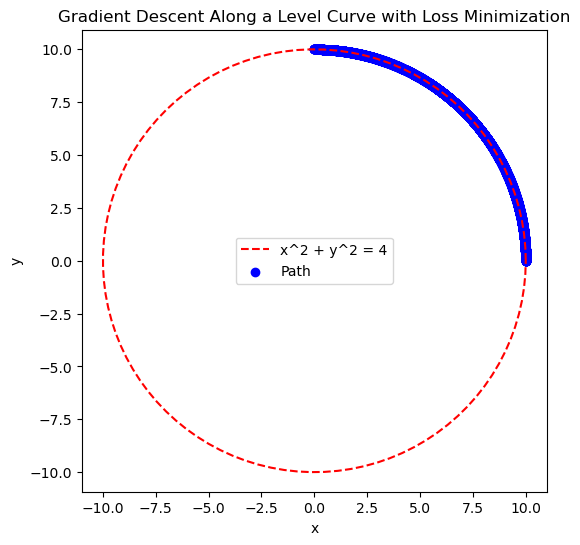

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def f(x, y):
    """ Function representing the surface z = f(x, y). """
    return x**2 + y**2

def gradient_f(x, y):
    """ Gradient of the function f(x, y). """
    dfdx = 2*x
    dfdy = 2*y
    return np.array([dfdx, dfdy], dtype=np.float64)

def loss_gradient_f(x, y, target_z):
    """ Gradient of the squared error loss function. """
    error = f(x, y) - target_z
    grad_f = gradient_f(x, y)
    # Gradient of the loss function with respect to x and y
    return 2 * error * grad_f

def gradient_descent_constrained(start_point, target_z, step_size, num_steps):
    """ Performs constrained gradient descent to move along a level curve, adjusting by loss. """
    path = [start_point]
    x, y = start_point
    
    for _ in range(num_steps):
        grad_loss = loss_gradient_f(x, y, target_z)
        
        grad = gradient_f(x, y)
        # Move in direction perpendicular to gradient: Rotate gradient by 90 degrees
        tangent_direction = np.array([-grad[1], grad[0]])
        tangent_direction /= np.linalg.norm(tangent_direction) # Normalize to step size
        
        # Move in direction that minimizes the loss, correcting direction
        x = x + step_size * (tangent_direction[0] - grad_loss[0])
        y = y + step_size * (tangent_direction[1] - grad_loss[1])
        
        # # Check if the new point maintains the constraint f(x, y) = target_z
        # if np.abs(f(x, y) - target_z) == 0:  # Small threshold for numerical stability
        #     # path.append((x, y))
        #     x_temp, y_temp = MoveAnyway(x, y)
        #     path.append((x_temp, y_temp))
        #     x = x_temp
        #     y = y_temp
        # else:
        #     path.append((x, y)) # Break if the constraint is not maintained
        path.append((x, y)) 
    
    return np.array(path)

# Settings : a test for total arc length pi : step_size * num_steps
start_point = (10, 0)
target_z = 100
step_size = 0.001  # Smaller step size for finer control
num_steps = 5*3141

# Perform constrained gradient descent
path = gradient_descent_constrained(start_point, target_z, step_size, num_steps)

# Plotting
plt.figure(figsize=(6, 6))
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(10*np.cos(theta), 10*np.sin(theta), 'r--', label='x^2 + y^2 = 4')
plt.scatter(path[:, 0], path[:, 1], c='b', label='Path')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.legend()
plt.title('Gradient Descent Along a Level Curve with Loss Minimization')
plt.show()


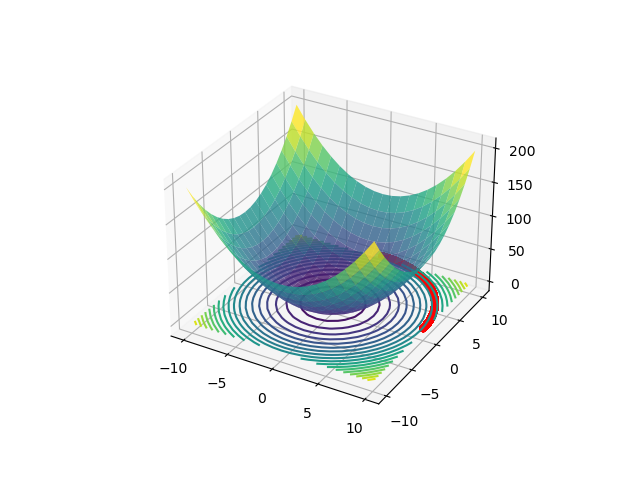

In [2]:
%matplotlib widget

x = np.linspace(-10, 10, 21)
y = np.linspace(-10, 10, 21)
coeff = np.array([[0, 0, 1], [0, 0, 0], [1, 0, 0]])

X, Y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

# Plot surface
surface = np.polynomial.polynomial.polygrid2d(x, y, coeff)
surf = ax.plot_surface(X, Y, surface.T, cmap="viridis", alpha=0.8)

# Plot contour lines on the surface
num_levels = 20
contour_levels = np.linspace(np.min(surface), np.max(surface), num_levels)
contour_surf = ax.contour(X, Y, surface.T, levels=contour_levels, offset=np.min(surface), cmap='viridis')

zs = np.full(path.shape[0], 4)
ax.scatter(path[:, 0], path[:, 1], zs, color='r')

plt.show()

### Measurement model

In [3]:
def polyfit2d(x, y, z, kx=3, ky=3, order=None):
    """
    Two dimensional polynomial fitting by least squares.
    Fits the functional form f(x,y) = z.

    Notes
    -----
    Resultant fit can be plotted with:
    np.polynomial.polynomial.polygrid2d(x, y, soln.reshape((kx+1, ky+1)))

    Parameters
    ----------
    x, y: array-like, 1d
        x and y coordinates.
    z: np.ndarray, 2d
        Surface to fit.
    kx, ky: int, default is 3
        Polynomial order in x and y, respectively.
    order: int or None, default is None
        If None, all coefficients up to maxiumum kx, ky, ie. up to and including x^kx*y^ky, are considered.
        If int, coefficients up to a maximum of kx+ky <= order are considered.

    Returns
    -------
    Return paramters from np.linalg.lstsq.

    soln: np.ndarray
        Array of polynomial coefficients.
    residuals: np.ndarray
    rank: int
    s: np.ndarray

    """

    # grid coords
    x, y = np.meshgrid(x, y)
    # coefficient array, up to x^kx, y^ky
    coeffs = np.ones((kx + 1, ky + 1))

    # solve array
    a = np.zeros((coeffs.size, x.size))

    # for each coefficient produce array x^i, y^j
    for index, (i, j) in enumerate(np.ndindex(coeffs.shape)):
        # do not include powers greater than order
        if order is not None and i + j > order:
            arr = np.zeros_like(x)
        else:
            arr = coeffs[i, j] * x**i * y**j
        a[index] = arr.ravel()

    # do leastsq fitting and return leastsq result
    print(a.T.shape, np.ravel(z).shape)
    return np.linalg.lstsq(a.T, np.ravel(z), rcond=None)

In [4]:
import pandas as pd

dataframe = pd.read_excel("Data/0-CalibrationData/30031142/FullRangeData_y.xlsx", sheet_name="FormatedWholeRang_ManuallyFixed")

z = np.array(dataframe)[:, 2]

x_len = 21
y_len = 10

x = np.linspace(0, 100, x_len)
y = np.linspace(130, 180, y_len)

# previously : kx - 4, ky - 4 for all bivariate polynoimial model
coeff, r, rank, s = polyfit2d(x, y, z, kx=3, ky=3)

(210, 16) (210,)


In [5]:
z

array([ 8002.11235135,  7912.86313178,  7792.61391222,  7632.30383626,
        7436.23718587,  7185.80539714,  6892.82981283,  6554.73112305,
        6172.71670573,  5755.65483236,  5298.52339518,  4850.94237142,
        4434.82786133,  4036.52058675,  3644.3154541 ,  3294.37968018,
        2978.02523275,  2718.62185547,  2421.25109809,  2133.37218574,
        1845.49327338,  8298.41756462,  8188.24293294,  8058.189611  ,
        7898.68218424,  7691.77807943,  7446.57554036,  7136.21083496,
        6770.15733398,  6358.69325684,  5897.9129362 ,  5344.86627848,
        4783.06235352,  4308.35690267,  3846.86184652,  3416.52687337,
        3025.42848226,  2668.72547363,  2379.77053304,  2129.11528158,
        1888.68862264,  1574.41870524,  8520.76222249,  8441.86219076,
        8336.16723633,  8184.28816569,  7983.84811361,  7723.20992513,
        7401.96592936,  7016.47184082,  6556.88714355,  6039.14532389,
        5364.09845215,  4679.41102539,  4125.0472526 ,  3590.72643636,
      

In [6]:
from sklearn.metrics import r2_score

print("Fitted results on Y-axis of magentic flux measurement: ")

fitted_surf = np.polynomial.polynomial.polygrid2d(x, y, coeff.reshape((4, 4)))

rms_y = np.sqrt(np.mean((z.reshape(y_len, x_len).T - fitted_surf) ** 2))
print("RMS residual =", rms_y)
score_y = r2_score(z.reshape(y_len, x_len).T, fitted_surf)
print("R-squared value =", score_y)

Fitted results on Y-axis of magentic flux measurement: 
RMS residual = 462.9466217848052
R-squared value = 0.9927418219305728


In [7]:
import sympy as sp

# Initialize the polynomial expression and coefficient matrix
polynomial = 0
coeff_matrix = coeff.reshape((4, 4))

# Define the symbolic variables
x, y, z = sp.symbols('x y z', positive=True)

# Add constraints to reduce solutions on y
# constraint1 :

# Iterate over each element in the matrix to construct the polynomial expression
for i in range(coeff_matrix.shape[0]):  
    for j in range(coeff_matrix.shape[1]): 
        polynomial += coeff_matrix[i, j] * (x**i) * (y**j)

In [8]:
coeff

array([-3.16722556e-01, -1.82496011e+01,  1.21818472e+00, -4.70079636e-03,
        1.92837276e+00,  1.44167553e+01, -2.23303285e-01,  8.66299481e-04,
        5.60941124e+01, -1.51143032e+00,  1.34277641e-02, -4.01178476e-05,
       -6.35580045e-01,  1.52306920e-02, -1.23081179e-04,  3.39171958e-07])

In [9]:
polynomial

3.39171957710271e-7*x**3*y**3 - 0.000123081179238376*x**3*y**2 + 0.0152306919640345*x**3*y - 0.635580045012618*x**3 - 4.01178475646262e-5*x**2*y**3 + 0.0134277640955505*x**2*y**2 - 1.51143031829683*x**2*y + 56.0941123551036*x**2 + 0.000866299480777101*x*y**3 - 0.223303284799815*x*y**2 + 14.4167552841376*x*y + 1.92837275763761*x - 0.00470079635785575*y**3 + 1.2181847239872*y**2 - 18.249601064668*y - 0.316722556202559

In [10]:
sp.diff(polynomial, x)

1.01751587313081e-6*x**2*y**3 - 0.000369243537715127*x**2*y**2 + 0.0456920758921035*x**2*y - 1.90674013503785*x**2 - 8.02356951292525e-5*x*y**3 + 0.026855528191101*x*y**2 - 3.02286063659366*x*y + 112.188224710207*x + 0.000866299480777101*y**3 - 0.223303284799815*y**2 + 14.4167552841376*y + 1.92837275763761

In [11]:
sp.diff(polynomial, y)

1.01751587313081e-6*x**3*y**2 - 0.000246162358476751*x**3*y + 0.0152306919640345*x**3 - 0.000120353542693879*x**2*y**2 + 0.026855528191101*x**2*y - 1.51143031829683*x**2 + 0.0025988984423313*x*y**2 - 0.446606569599629*x*y + 14.4167552841376*x - 0.0141023890735672*y**2 + 2.4363694479744*y - 18.249601064668

In [12]:
print(sp.diff(polynomial, x))

1.01751587313081e-6*x**2*y**3 - 0.000369243537715127*x**2*y**2 + 0.0456920758921035*x**2*y - 1.90674013503785*x**2 - 8.02356951292525e-5*x*y**3 + 0.026855528191101*x*y**2 - 3.02286063659366*x*y + 112.188224710207*x + 0.000866299480777101*y**3 - 0.223303284799815*y**2 + 14.4167552841376*y + 1.92837275763761


### Test

In [13]:
from sympy.abc import x, y, z

# Both works

def z_polyval(x, y, coeff):
    """ Function representing the surface z = f(x, y). """
    return np.polynomial.polynomial.polyval2d(float(x), float(y), coeff.reshape((4, 4)))

def z_subs(a, b):
    polynomial = 3.39171957710271e-7*x**3*y**3 - 0.000123081179238376*x**3*y**2 + 0.0152306919640345*x**3*y - 0.635580045012618*x**3 - 4.01178475646262e-5*x**2*y**3 + 0.0134277640955505*x**2*y**2 - 1.51143031829683*x**2*y + 56.0941123551036*x**2 + 0.000866299480777101*x*y**3 - 0.223303284799815*x*y**2 + 14.4167552841376*x*y + 1.92837275763761*x - 0.00470079635785575*y**3 + 1.2181847239872*y**2 - 18.249601064668*y - 0.316722556202559
    return polynomial.subs({x: float(a), y: float(b)})

def gradient_z(x, y):
    """ Gradient of the function f(x, y). """ 
    dzdx = 1.01751587313081e-6*x**2*y**3 - 0.000369243537715127*x**2*y**2 + 0.0456920758921035*x**2*y - 1.90674013503785*x**2 - 8.02356951292525e-5*x*y**3 + 0.026855528191101*x*y**2 - 3.02286063659366*x*y + 112.188224710207*x + 0.000866299480777101*y**3 - 0.223303284799815*y**2 + 14.4167552841376*y + 1.92837275763761
    dzdy = 1.01751587313081e-6*x**3*y**2 - 0.000246162358476751*x**3*y + 0.0152306919640345*x**3 - 0.000120353542693879*x**2*y**2 + 0.026855528191101*x**2*y - 1.51143031829683*x**2 + 0.0025988984423313*x*y**2 - 0.446606569599629*x*y + 14.4167552841376*x - 0.0141023890735672*y**2 + 2.4363694479744*y - 18.249601064668
    return np.array([dzdx, dzdy], dtype=np.float64)

# def gradient_z_decimal(x, y):

# It suffered a major numerical computation issue previously, the calculation inputs seems too large: 
# RuntimeWarning: invalid value encountered in multiply
# RuntimeWarning: invalid value encountered in divide

# Therefore with decimal function, i tried to reduce the float number length considering it is necessary
# to maintain the order of the polynomial measurement model to ensure an accurate fit on sensor. Yet it 
# doesn't work. After debug step by step, i found it is because the scale of current measurement model is
# to large, that is to say the value z is too large, since that the loss gradient outputs were untolerently
# large. Of course it is, i didn't even try to first normalize it...

def loss_gradient_z(x, y, target_z):
    """ Gradient of the squared error loss function. """
    error = z_polyval(x, y, coeff) - target_z
    grad_z = gradient_z(x, y)
    # Gradient of the loss function with respect to x and y
    return 2 * error * grad_z

In [14]:
z_polyval(35, 170, coeff)

8536.999834757618

In [15]:
z_subs(35, 170)

8536.99983475731

In [16]:
def gradient_descent_constrained_z(start_point, target_z, step_size, arc_length):
    """ Performs constrained gradient descent to move along a level curve, adjusting by loss. """
    path = [start_point]
    x, y = start_point
    delta_dis = 0
    
    while True and delta_dis <= arc_length:
        
        grad_loss = loss_gradient_z(x, y, target_z)
        # Move in direction that minimizes the loss, correcting direction
        loss_direction = np.array([grad_loss[0], grad_loss[1]])
        loss_direction /= np.linalg.norm(loss_direction) # Normalize to step size
        
        grad_tangent = gradient_z(x, y)
        # Move in direction perpendicular to gradient: Rotate gradient by 90 degrees
        tangent_direction = np.array([-grad_tangent[1], grad_tangent[0]])
        tangent_direction /= np.linalg.norm(tangent_direction) # Normalize to step size
    
        dx = step_size * (tangent_direction[0] - loss_direction[0])
        dy = step_size * (tangent_direction[1] - loss_direction[1])
        delta_dis += np.sqrt(dx**2 + dy**2)
        
        x += dx
        y += dy
        
        path.append((x, y)) 
    
    return np.array(path)

# Settings : a test for total arc length pi : step_size * num_steps
start_point = (35, 170)
target_z = 8536.9998
step_size = 0.01  # Smaller step size for finer control
arc_length = 70 # unit : mm

# Perform constrained gradient descent
path = gradient_descent_constrained_z(start_point, target_z, step_size, arc_length)

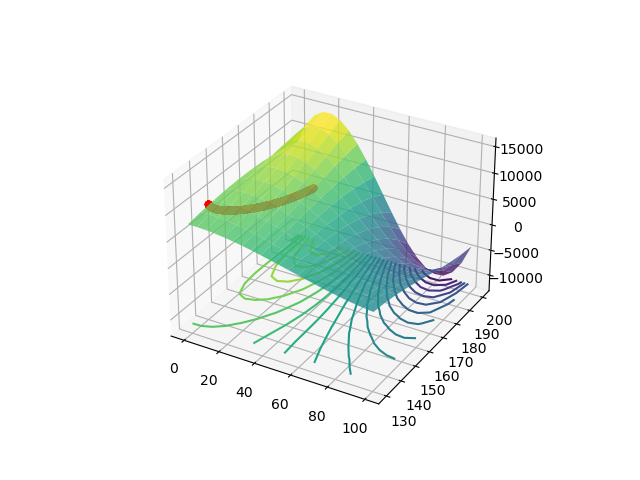

In [17]:
%matplotlib widget

x = np.linspace(0, 100, 21)
y = np.linspace(130, 200, 10)

X, Y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

# Plot surface
surface = np.polynomial.polynomial.polygrid2d(x, y, coeff.reshape((4, 4)))
surf = ax.plot_surface(X, Y, surface.T, cmap="viridis", alpha=0.8)

# Plot contour lines on the surface
num_levels = 20
contour_levels = np.linspace(np.min(surface), np.max(surface), num_levels)
contour_surf = ax.contour(X, Y, surface.T, levels=contour_levels, offset=np.min(surface), cmap='viridis')

zs = np.full(path.shape[0], target_z)
ax.scatter(path[:, 0], path[:, 1], zs, color='r')

plt.show()